In [1]:
import numpy as np
import astropy.io.fits as afits
import matplotlib.pyplot as plt
import apogee.tools.read as apread
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples
from sklearn.metrics.pairwise import euclidean_distances
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [44]:
from matplotlib.colors import LogNorm
default_cmap='gray_r'

In [46]:
fs = 16
#plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=fs)

In [3]:
from apogee.tools.path import change_dr

In [43]:
def histogram2d(fig,ax,x,y,bins=100,clabel=False,vmin=0,vmax=110,norm='lin',default_cmap=default_cmap):
    """
    Create a 2D histogram of data represented by the two dimensions x and y
    
    fig:      Figure to plot in
    ax:       Subplot object to plot in
    x:        Array of data values in 'x'
    y:        Array of data values in 'y'
    bins:     Number of bins in which to divide each axis
    clabel:   Label for the colourbar - no colourbar is plotted if this is not given
    vmin:     Minimum value of the histogram
    vmax:     Maximum value of the histogram
    
    """
    # Create histogram
    H,xedges,yedges = np.histogram2d(x,y,bins=bins)
    # Reorient appropriately
    H = np.rot90(H)
    H = np.flipud(H)
    # Mask where bins are empty
    Hmasked = np.ma.masked_where(H==0,H)
    # Plot histogram
    if norm == 'lin':
        im = ax.pcolormesh(xedges,yedges,Hmasked,
                           cmap = plt.get_cmap(default_cmap),
                           vmin=vmin,vmax=vmax,rasterized=True)
    elif norm == 'log':
            im = ax.pcolormesh(xedges,yedges,Hmasked,
                           cmap = plt.get_cmap(default_cmap),
                           norm=LogNorm(vmin=vmin,vmax=vmax),rasterized=True)
    # If colourbar is desired, plot and label it
    if clabel:
        cbar=fig.colorbar(im,pad = 0)
        cbar.set_label(label=clabel,fontsize=fs)
        cbar.ax.tick_params(labelsize=fs)
    elif not clabel:
        cbar=fig.colorbar(im,pad = 0)
        cbar.ax.tick_params(labelsize=fs)
        
def membercount(labels):
    """
    For a list of labels, return the number of objects with each label.

    labels:   label for each object of interest

    Returns membership for each label and the corresponding labels.
    """
    ulab = np.unique(labels)
    members = np.zeros(len(ulab))
    for u in range(len(ulab)):
        members[u] = len(np.where(labels==ulab[u])[0])
    return members,ulab

def sortmembercount(labels):
    """
    For a list of labels, return the number of objects with each label sorted
    so the largest group is first.        
                                                                               
    labels:   label for each object of interest                                
                                                                            
    Returns sorted membership for each label and the corresponding labels. 
    """
    ulab = np.unique(labels)
    members = np.zeros(len(ulab))
    for u in range(len(ulab)):
        members[u] = len(np.where(labels==ulab[u])[0])
    sizelist = np.argsort(members)[::-1]
    return members[sizelist],ulab[sizelist]

def crossmatch(labels_pred,labels_true,minmembers=1):
    """
    Match each found cluster to the original cluster that contributed the 
    majority of its members.

    labels_pred:   Labels for each object matching to found clusters.
    labels_true:   Labels for each object matching to the original clusters.
    minmembers:   Only consider clusters larger than the given size.

    Returns list of found labels and matched true labels.
    """
    plabs = (np.unique(labels_pred)).astype(int)
    bad = np.where(plabs==-1)
    if len(bad[0])>0:
        plabs = np.delete(plabs,bad[0][0])
    tlabs = -np.ones(plabs.shape,dtype=int)
    for p in range(len(plabs)):
        predmatch = np.where(labels_pred==plabs[p])
        if len(labels_pred[predmatch])>=minmembers:
            truepredmatch = labels_true[predmatch]
            truecounts,trueinds = sortmembercount(truepredmatch)
            tlabs[p]=trueinds[0] #stands for majority stakeholder
    return plabs,tlabs
    
def efficiency_completeness(labels_pred,
                            labels_true,
                            minmembers=1):
    """
    Compute the efficiency and completeness for each cluster in a sample.

    labels_pred:   Labels for each object matching to found clusters.         
    labels_true:   Labels for each object matching to the original clusters.    
    minmembers:   Only consider clusters larger than the given size.  
    
    Returns lists of efficiency, completeness, found labels and 
    matched true labels.
    """
    plabs,tlabs = crossmatch(labels_pred,labels_true,minmembers=minmembers)
    bad = np.where(plabs==-1)
    if len(bad[0])>0:
        plabs = np.delete(plabs,bad[0][0])
    # Initialize output as disallowed values.
    efficiency = -np.ones(plabs.shape)
    completeness = -np.ones(plabs.shape)
    # Go through all found clusters
    for p in range(len(plabs)):
        predmatch = np.where(labels_pred==plabs[p])
        pred_pred = labels_pred[predmatch]
        true_pred = labels_true[predmatch]
        # Proceed if cluster is large enough
        if len(pred_pred)>=minmembers:
            # Find all members of the matched original cluster
            truematch = np.where(labels_true==tlabs[p])
            true_true = labels_true[truematch]
            # Find all members of the matched original cluster in the 
            # found cluster
            predtruematch = np.where((labels_true==tlabs[p]) & (labels_pred==plabs[p]))
            pred_predtrue = labels_pred[predtruematch]
            # Find the number of stars in the found cluster
            Nrecover = len(pred_pred)
            # Find the number of stars in the original cluster
            Noriginal = len(true_true)
            # Find the number of stars of the original cluster in the 
            # found cluster
            Nmajority = len(pred_predtrue)
            # Find efficiency and completeness
            efficiency[p] = Nmajority/Nrecover
            completeness[p] = Nmajority/Noriginal
    return efficiency, completeness, plabs, tlabs

In [5]:
change_dr('14')

In [6]:
allStar= apread.allStar(use_astroNN=True)

/home/price-jones/local/lib/python3.6/site-packages/apogee-1.-py3.6.egg/apogee/tools/read.py:1138: UserWarning: Swapping in stellar parameters and abundances from Leung & Bovy (2019a)
  warnings.warn("Swapping in stellar parameters and abundances from Leung & Bovy (2019a)")
/home/price-jones/local/lib/python3.6/site-packages/apogee-1.-py3.6.egg/apogee/tools/read.py:1141: UserWarning: Adding distances from Leung & Bovy (2019b)
  warnings.warn("Adding distances from Leung & Bovy (2019b)")
/home/price-jones/local/lib/python3.6/site-packages/apogee-1.-py3.6.egg/apogee/tools/read.py:1144: UserWarning: Adding ages from Mackereth, Bovy, Leung, et al. (2019)
  warnings.warn("Adding ages from Mackereth, Bovy, Leung, et al. (2019)")


In [7]:
allStar.dtype

dtype([('APSTAR_ID', 'S45'), ('TARGET_ID', 'S34'), ('ASPCAP_ID', 'S46'), ('FILE', 'S38'), ('APOGEE_ID', 'S18'), ('TELESCOPE', 'S8'), ('LOCATION_ID', '>i2'), ('FIELD', 'S16'), ('J', '>f4'), ('J_ERR', '>f4'), ('H', '>f4'), ('H_ERR', '>f4'), ('K', '>f4'), ('K_ERR', '>f4'), ('RA', '>f8'), ('DEC', '>f8'), ('GLON', '>f8'), ('GLAT', '>f8'), ('APOGEE_TARGET1', '>i4'), ('APOGEE_TARGET2', '>i4'), ('APOGEE_TARGET3', '>i4'), ('TARGFLAGS', 'S140'), ('SURVEY', 'S14'), ('NINST', '>i4', (3,)), ('NVISITS', '>i4'), ('COMBTYPE', '>i4'), ('COMMISS', '>i2'), ('SNR', '>f4'), ('STARFLAG', '>i4'), ('STARFLAGS', 'S165'), ('ANDFLAG', '>i4'), ('ANDFLAGS', 'S74'), ('VHELIO_AVG', '>f4'), ('VSCATTER', '>f4'), ('VERR', '>f4'), ('VERR_MED', '>f4'), ('OBSVHELIO_AVG', '>f4'), ('OBSVSCATTER', '>f4'), ('OBSVERR', '>f4'), ('OBSVERR_MED', '>f4'), ('SYNTHVHELIO_AVG', '>f4'), ('SYNTHVSCATTER', '>f4'), ('SYNTHVERR', '>f4'), ('SYNTHVERR_MED', '>f4'), ('RV_TEFF', '>f4'), ('RV_LOGG', '>f4'), ('RV_FEH', '>f4'), ('RV_ALPHA', '>f4'

In [8]:
def gen_condition(elems,uplim,downlim,snrlim):
    good = (allStar['SNR']>snrlim)
    for elem in elems:
        if elem != 'FE':
            suff = 'FE'
        elif elem == 'FE':
            suff = 'H'
        good = good & (allStar['{0}_{1}_ERR'.format(elem,suff)] < uplim) & (allStar['{0}_{1}_ERR'.format(elem,suff)] > downlim)
    return good

C_FE_ERR
N_FE_ERR
O_FE_ERR
MG_FE_ERR
AL_FE_ERR
SI_FE_ERR
S_FE_ERR
K_FE_ERR
CA_FE_ERR
TI_FE_ERR
V_FE_ERR
MN_FE_ERR
FE_H_ERR
NI_FE_ERR


(array([2.3350e+04, 1.0006e+04, 3.2590e+03, 1.3650e+03, 5.7700e+02,
        2.2900e+02, 9.3000e+01, 1.2000e+01, 9.0000e+00, 2.0000e+00]),
 array([  50.05920029,  251.94327049,  453.8273407 ,  655.7114109 ,
         857.59548111, 1059.47955132, 1261.36362152, 1463.24769173,
        1665.13176193, 1867.01583214, 2068.89990234]),
 <a list of 10 Patch objects>)

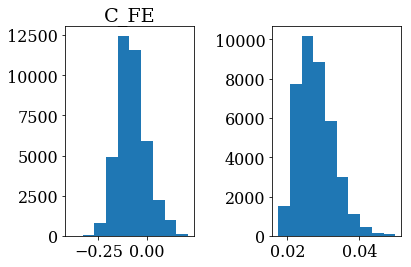

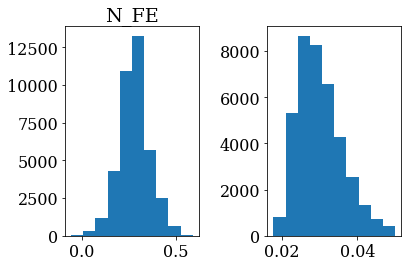

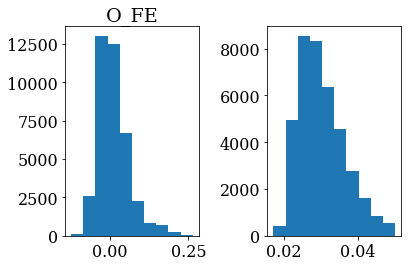

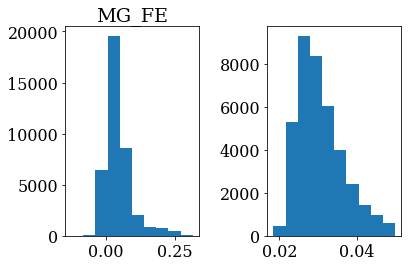

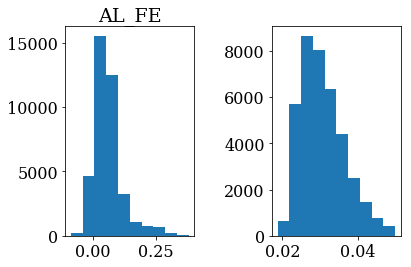

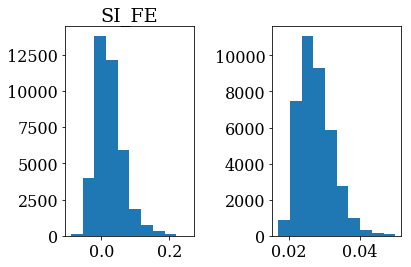

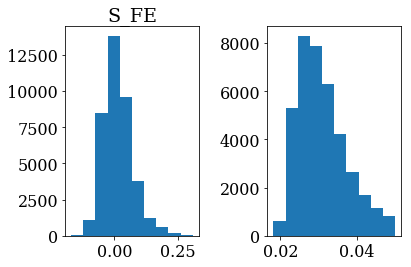

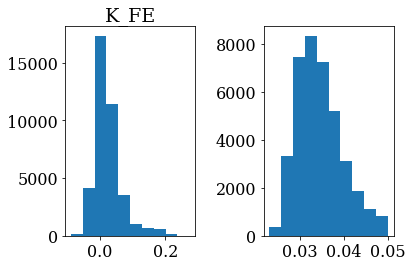

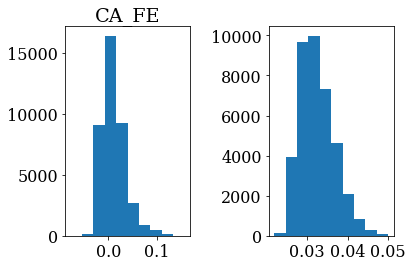

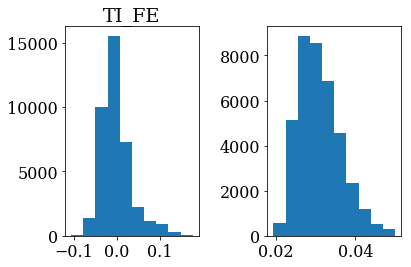

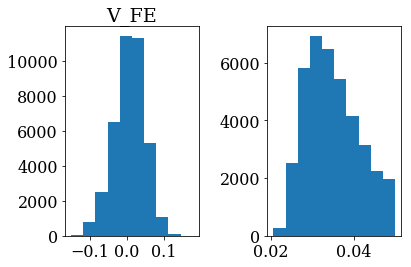

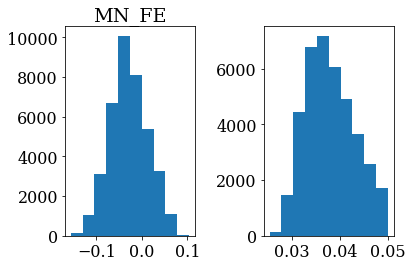

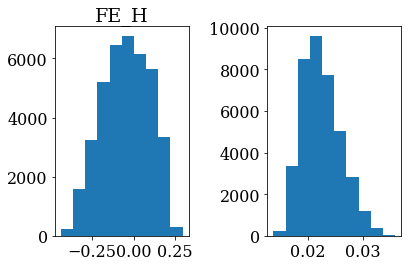

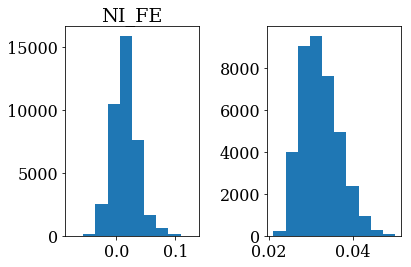

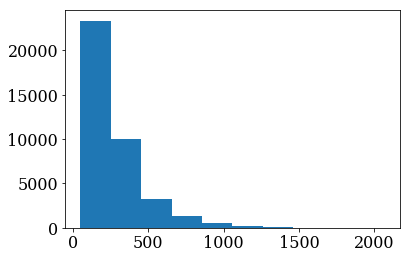

In [9]:
#elems = ['C','N','O','MG','AL','SI','P','S','K','CA','TI','V','CR','MN','FE','CO','NI']
elems = ['C','N','O','MG','AL','SI','S','K','CA','TI','V','MN','FE','NI']
#elems = ['C','O','MG','AL','SI','S','CA','MN','FE','NI']
#elems = ['C','N','O','MG','AL','SI','K','CA','FE','NI']
def gen_condition(elems,uplim,downlim,snrlim):
    good = (allStar['SNR']>snrlim)
    for elem in elems:
        if elem != 'FE':
            suff = 'FE'
        elif elem == 'FE':
            suff = 'H'
        print('{0}_{1}_ERR'.format(elem,suff))
        good = good & (allStar['{0}_{1}_ERR'.format(elem,suff)] < uplim) & (allStar['{0}_{1}_ERR'.format(elem,suff)] > downlim)
    return good
keys = []
uplim = 0.05
downlim = -1000
#goodstars = (allStar['SNR'] > 50) & (allStar['C_FE_ERR'] < uplim) & (allStar['C_FE_ERR'] > downlim) & (allStar['N_FE_ERR'] < uplim) & (allStar['N_FE_ERR'] > downlim) & (allStar['O_FE_ERR'] < uplim) & (allStar['O_FE_ERR'] > downlim) & (allStar['MG_FE_ERR'] < uplim) & (allStar['MG_FE_ERR'] > downlim) & (allStar['AL_FE_ERR'] < uplim) & (allStar['AL_FE_ERR'] > downlim) & (allStar['SI_FE_ERR'] < uplim) & (allStar['SI_FE_ERR'] > downlim) & (allStar['P_FE_ERR'] < uplim) & (allStar['P_FE_ERR'] > downlim) & (allStar['K_FE_ERR'] < uplim) & (allStar['K_FE_ERR'] > downlim) & (allStar['CA_FE_ERR'] < uplim) & (allStar['CA_FE_ERR'] > downlim) & (allStar['TI_FE_ERR'] < uplim) & (allStar['TI_FE_ERR'] > downlim) & (allStar['V_FE_ERR'] < uplim) & (allStar['V_FE_ERR'] > downlim) & (allStar['CR_FE_ERR'] < uplim) & (allStar['CR_FE_ERR'] > downlim) & (allStar['MN_FE_ERR'] < uplim) & (allStar['MN_FE_ERR'] > downlim) & (allStar['FE_H_ERR'] < uplim) & (allStar['FE_H_ERR'] > downlim) & (allStar['CO_FE_ERR'] < uplim) & (allStar['CO_FE_ERR'] > downlim) & (allStar['NI_FE_ERR'] < uplim) & (allStar['NI_FE_ERR'] > downlim) 
#goodstars = (allStar['SNR'] > 50) & (allStar['C_FE_ERR'] < uplim) & (allStar['C_FE_ERR'] > downlim) & (allStar['N_FE_ERR'] < uplim) & (allStar['N_FE_ERR'] > downlim) & (allStar['O_FE_ERR'] < uplim) & (allStar['O_FE_ERR'] > downlim) & (allStar['MG_FE_ERR'] < uplim) & (allStar['MG_FE_ERR'] > downlim) & (allStar['AL_FE_ERR'] < uplim) & (allStar['AL_FE_ERR'] > downlim) & (allStar['SI_FE_ERR'] < uplim) & (allStar['SI_FE_ERR'] > downlim) & (allStar['K_FE_ERR'] < uplim) & (allStar['K_FE_ERR'] > downlim) & (allStar['CA_FE_ERR'] < uplim) & (allStar['CA_FE_ERR'] > downlim) & (allStar['TI_FE_ERR'] < uplim) & (allStar['TI_FE_ERR'] > downlim) & (allStar['V_FE_ERR'] < uplim) & (allStar['V_FE_ERR'] > downlim) & (allStar['CR_FE_ERR'] < uplim) & (allStar['CR_FE_ERR'] > downlim) & (allStar['MN_FE_ERR'] < uplim) & (allStar['MN_FE_ERR'] > downlim) & (allStar['FE_H_ERR'] < uplim) & (allStar['FE_H_ERR'] > downlim) & (allStar['NI_FE_ERR'] < uplim) & (allStar['NI_FE_ERR'] > downlim) 
goodstars = gen_condition(elems,uplim,downlim,50)
#goodstars = allStar['SNR'] > 50
for elem in elems:
    if elem !='FE':
        key = '{0}_FE'.format(elem)
    if elem == 'FE':
        key = 'FE_H'
    keys.append(key)
    data = allStar[key]
    err = allStar['{0}_ERR'.format(key)]
    mask = (err > -1000) & (err < 0.05)
    plt.figure()
    plt.subplot(121)
    plt.title(key)
    plt.hist(data[goodstars])
    plt.subplot(122)
    plt.hist(err[goodstars])
    plt.tight_layout()
   
plt.figure()
plt.hist(allStar['SNR'][goodstars])

In [10]:
abundances = np.zeros((len(allStar[goodstars]),len(keys)),dtype=float)
#spectra = np.zeros()
for k,key in enumerate(keys):
    abundances[:,k] = allStar[goodstars][key]

In [11]:
abundances

array([[-1.01048820e-01,  1.65336668e-01, -4.93542627e-02, ...,
        -3.94659713e-02, -1.18326224e-01,  3.00747231e-02],
       [-1.92874521e-01,  4.00822550e-01, -3.23709995e-02, ...,
        -1.27307419e-02,  8.14643875e-03, -1.46993138e-02],
       [-9.67317820e-02,  2.90123403e-01, -1.51642673e-02, ...,
        -4.10324521e-03, -8.99723545e-03,  6.05995534e-03],
       ...,
       [-5.01913130e-02,  2.31693178e-01,  4.14820910e-02, ...,
        -7.89871067e-02, -1.74445555e-01,  3.04500312e-02],
       [-8.64941105e-02,  2.91168064e-01,  2.89998129e-02, ...,
        -3.61849740e-02,  6.41896157e-03,  3.68367881e-04],
       [-1.03148714e-01,  2.59494990e-01,  2.81726420e-02, ...,
        -3.44060063e-02, -1.57998815e-01,  1.80181563e-02]])

In [11]:
twod = TSNE(n_components=2).fit_transform(abundances)

KeyboardInterrupt: 

In [12]:
maxval=int(3e4)
dists = euclidean_distances(abundances,abundances)

In [13]:
typ = np.median(dists)

In [14]:
typ

0.2754146975077124

In [15]:
# 0.15 - 0.17 seems to do the trick, as predicted for the optimistic case from paper when using 17 elems
# 15 elems? - 0.125
#scalerange = np.arange(0.08,0.11,0.005) # 10 elems
scalerange = np.arange(0.1,0.14,0.005) # 15 elems
#scalerange = np.arange(0.15,0.20,0.005) # 17 elems
labellist = []
for s,scale in enumerate(scalerange):
    print(s+1,len(scalerange),scale)
    db = DBSCAN(min_samples=3,
                eps=scale*typ,n_jobs=1,
                metric='precomputed').fit(dists)
    labellist.append(db.labels_)
    

1 9 0.1
2 9 0.10500000000000001
3 9 0.11000000000000001
4 9 0.11500000000000002
5 9 0.12000000000000002
6 9 0.12500000000000003
7 9 0.13000000000000003
8 9 0.13500000000000004
9 9 0.14000000000000004


In [16]:

pcountls = []
plabls = []
csils = []
allsils = []
for l,labs in enumerate(labellist):
    print(l+1,len(scalerange))
    pcount,plabs = membercount(labs)
    minsize=9
    try:
        sils = silhouette_samples(abundances,labs)
    except ValueError:
        sils = -np.ones(len(labs))
    allsils.append(sils)
    clustersils = np.array([np.mean(sils[labs==lab]) for lab in plabs])
    goodlabs = (pcount>=minsize) & (plabs > -1) & (clustersils > 0)
    csils.append(clustersils)
    pcountls.append(pcount)
    plabls.append(plabs)

1 9
2 9
3 9
4 9
5 9
6 9
7 9
8 9
9 9


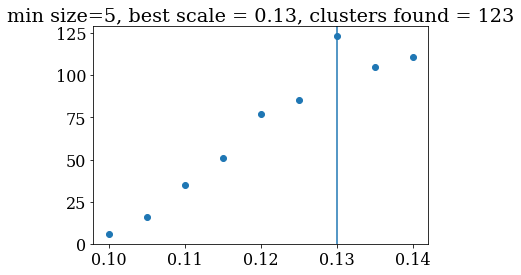

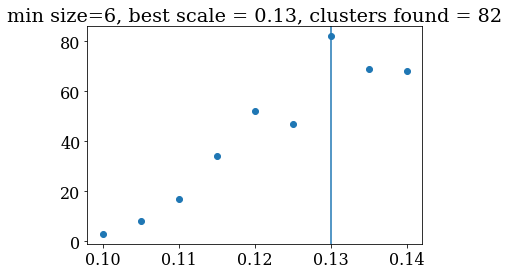

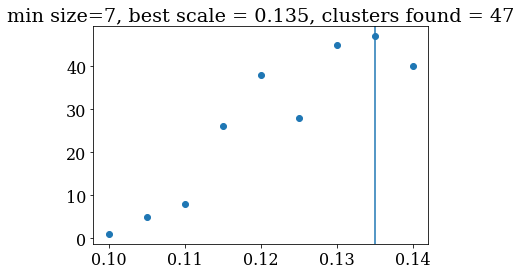

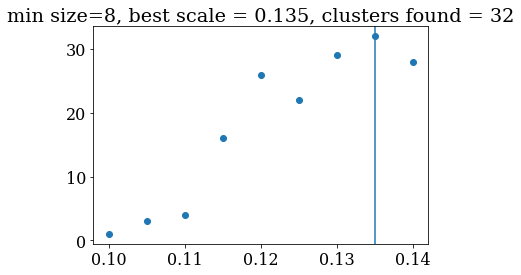

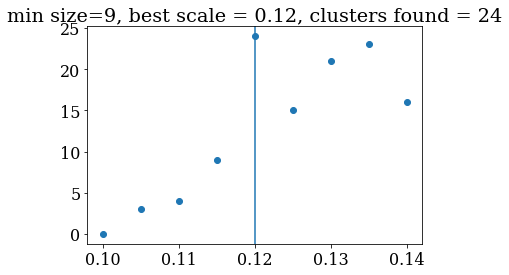

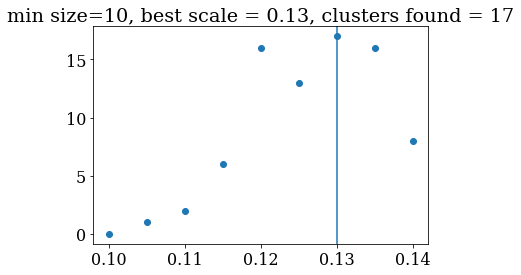

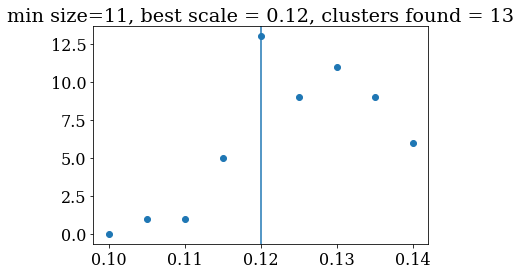

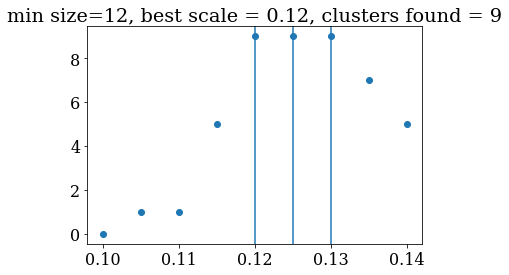

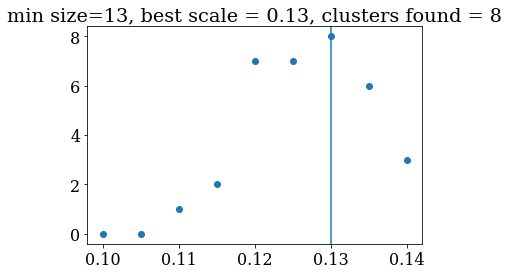

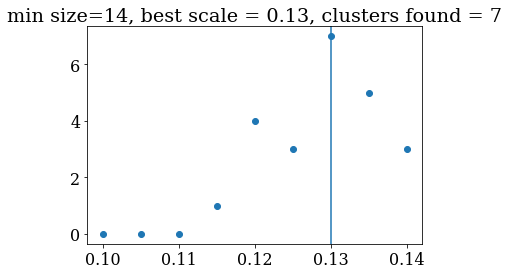

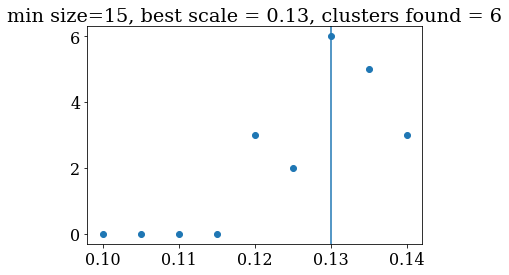

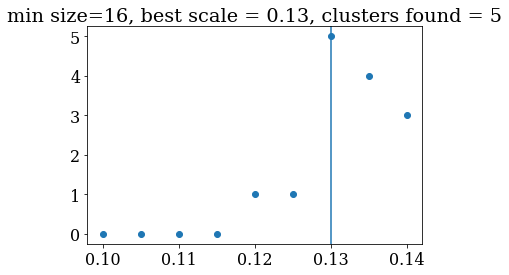

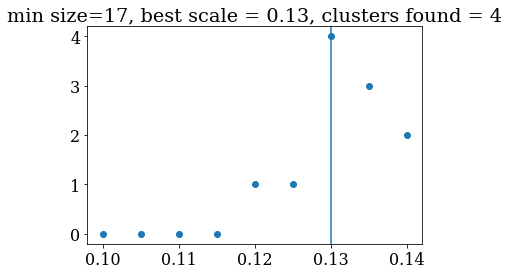

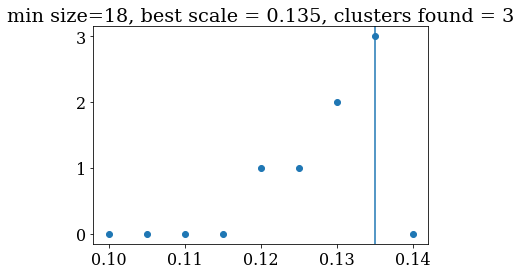

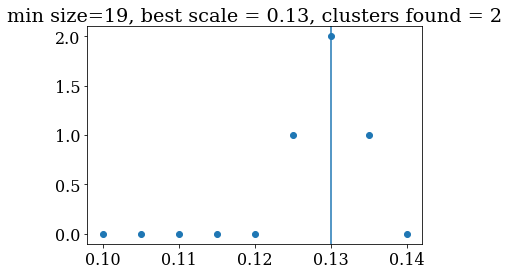

In [17]:
sizes = np.arange(5,20,1)
for minsize in sizes:
    plt.figure()
    nums = np.array([])
    for l,labs in enumerate(labellist):
        clustersils = csils[l]
        pcount = pcountls[l]
        plabs = plabls[l]
        goodlabs = (pcount>=minsize) & (plabs > -1) & (clustersils > 0)
        nums = np.append(nums,len(plabs[goodlabs]))
    maxnum = np.where(nums==np.max(nums))  
    for maxn in maxnum[0]:
        plt.axvline(scalerange[maxn])
    plt.plot(scalerange,nums,'o',color='C0')
    plt.title('min size={0}, best scale = {1}, clusters found = {2}'.format(minsize,np.round(scalerange[maxnum[0][0]],3),int(nums[maxnum[0][0]])))


In [19]:
scalerange[5]

0.12500000000000003

In [22]:
minsize=10
scale = 5
labs = labellist[scale]
clustersils = csils[scale]
pcount = pcountls[scale]
plabs = plabls[scale]
goodlabs = (pcount>=minsize) & (plabs > -1) & (clustersils > 0)
goodinds = []
recolour = []
colors = {}
c=0
for l,lab in enumerate(labs):
    if lab in plabs[goodlabs]:
        if lab not in list(colors.keys()):
            c+=1
            colors[lab] = c
        goodinds.append(l)
        recolour.append(colors[lab])

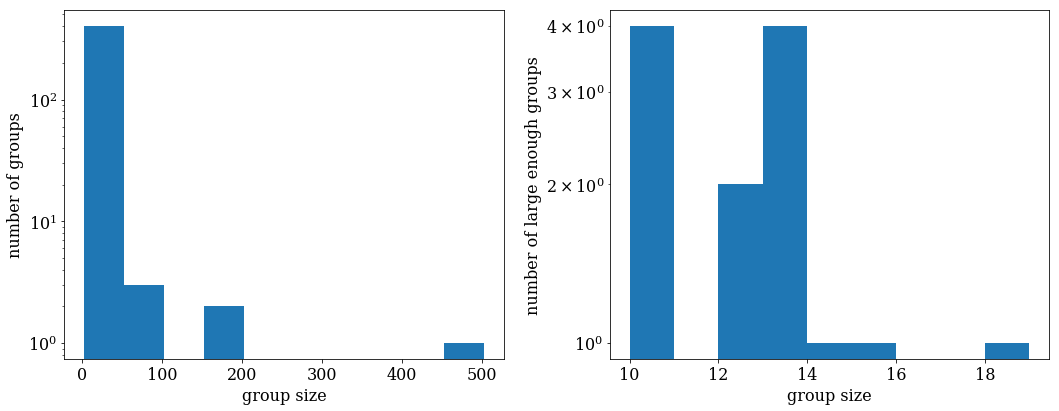

In [23]:
plt.figure(figsize=(15,6))
ax = plt.subplot(121)
ax.set_yscale('log')
plt.hist(pcount[plabs>-1])#,bins = np.arange(np.min(pcount[plabs>-1]),np.max(pcount[plabs>-1])+1))
plt.xlabel('group size')
plt.ylabel('number of groups')
ax = plt.subplot(122)
ax.set_yscale('log')
plt.hist(pcount[goodlabs],bins = np.arange(np.min(pcount[goodlabs]),np.max(pcount[goodlabs])+1))
plt.xlabel('group size')
plt.ylabel('number of large enough groups')
plt.tight_layout()
plt.savefig('minsize{0}_scale{1}_elems{2}_sizehist.jpg'.format(minsize,np.round(scalerange[scale],3),len(elems)))

In [24]:
cls = afits.open('occam_cluster-DR14.fits')
cls = cls[1].data
mem = afits.open('occam_member-DR14.fits')
mem = mem[1].data
apinds = np.array([],dtype=int)
clinds = np.array([],dtype=int)
for a,apoid in enumerate(mem['APOGEE_ID']):
    if mem['MEMBER_FLAG'][a]=='GM':
        match = np.where(apoid==(allStar[goodstars]['APOGEE_ID']).astype('U100'))
        if len(match[0])>0:
            apinds = np.append(apinds,match[0][0])
            clinds = np.append(clinds,a)
# apoids = np.in1d((allStar['APOGEE_ID'][goodstars]).astype('U100'),mem['APOGEE_ID'])
# memids = np.in1d(mem['APOGEE_ID'],(allStar['APOGEE_ID'][goodstars]).astype('U100'))
# openclschem = allStar[goodstars][apoids]
# opencls = mem[memids]

# ocsort = np.argsort(opencls['APOGEE_ID'])
# occhemsort = np.argsort(openclschem['APOGEE_ID'])
# opencls = opencls[ocsort]
# openclschem = openclschem[occhemsort]
#apoids = np.in1d((openclschem['APOGEE_ID']).astype('U100'),opencls['APOGEE_ID'])

In [25]:
ockeys = {}
oclabels = []
c = 0
for s,star in enumerate(mem[clinds]):
    if star['CLUSTER'] not in list(ockeys.keys()):
        ockeys[star['CLUSTER']]=c
        c+=1
    oclabels.append(ockeys[star['CLUSTER']])

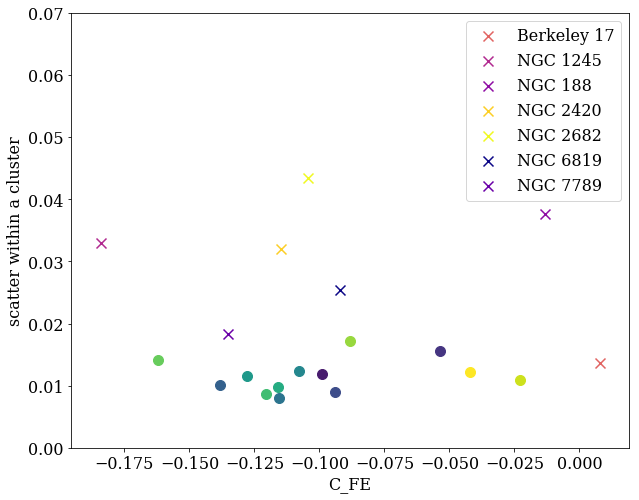

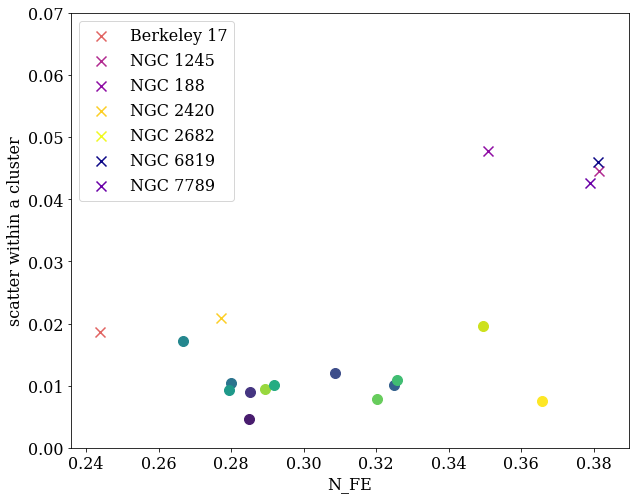

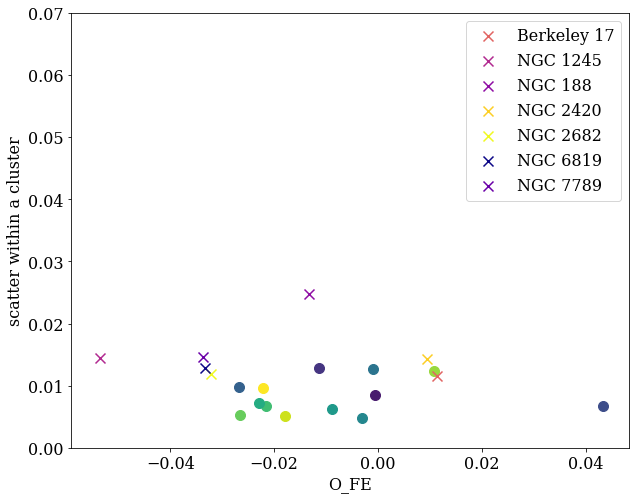

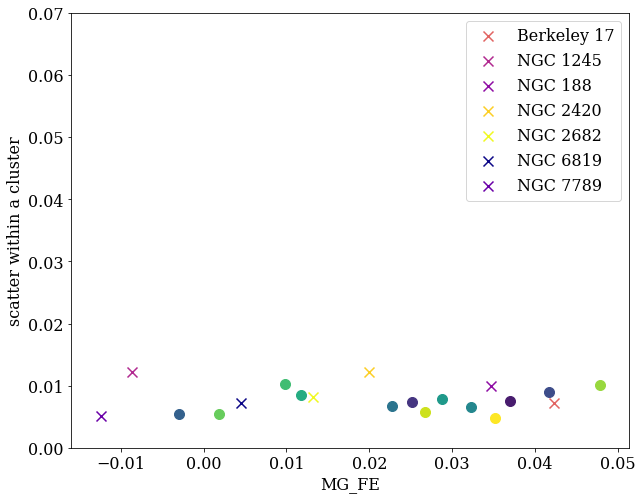

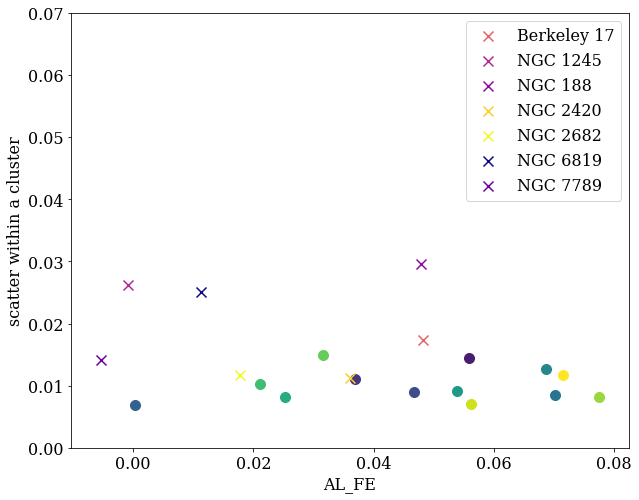

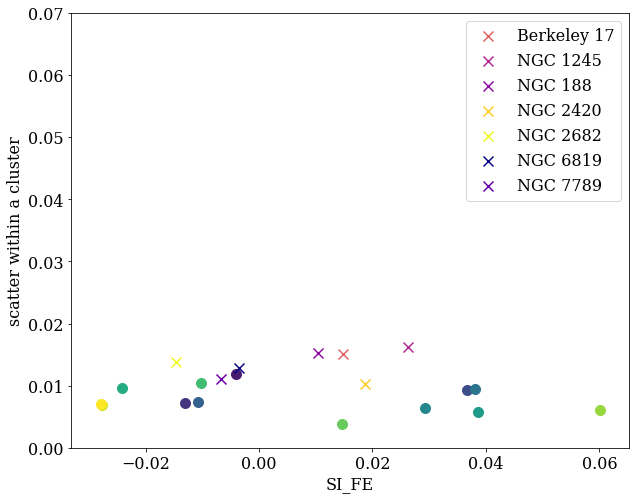

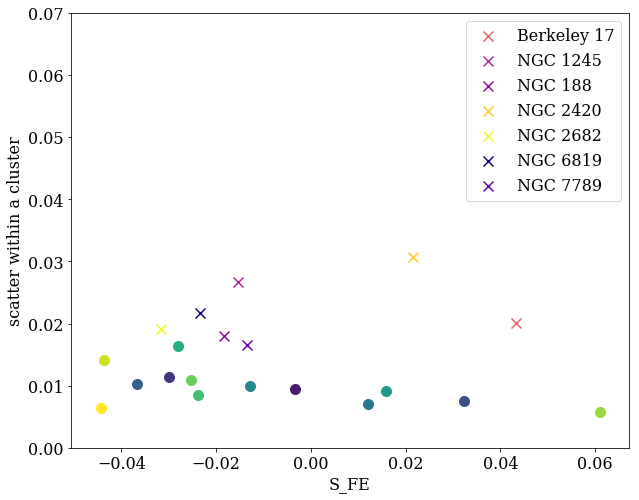

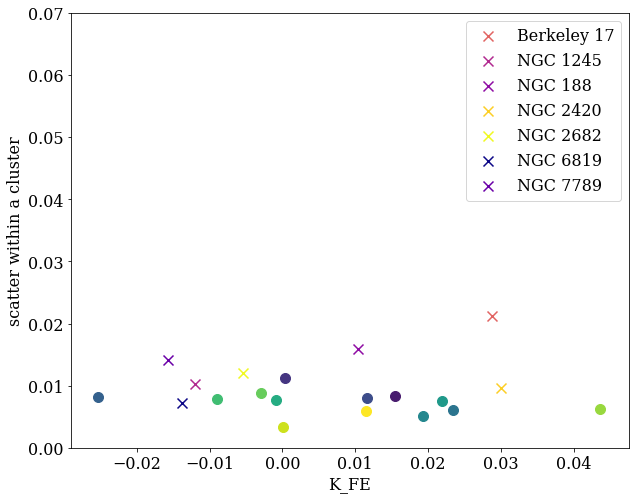

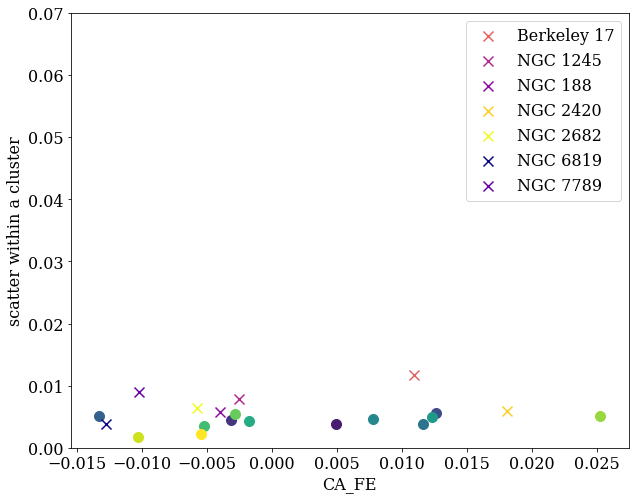

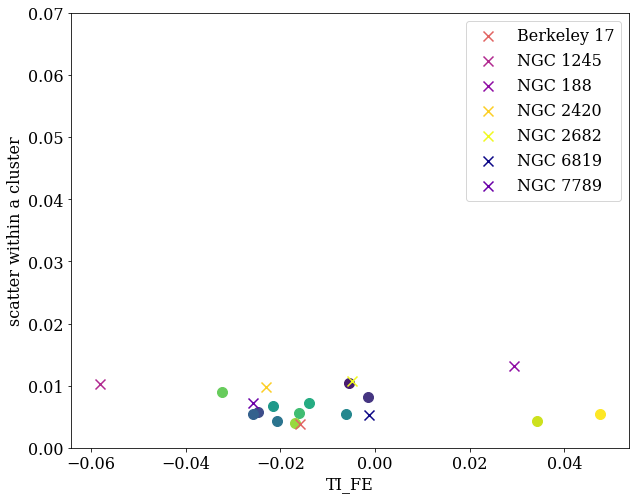

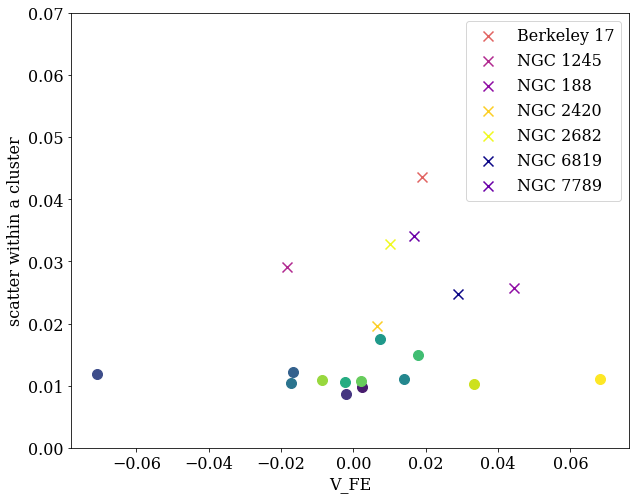

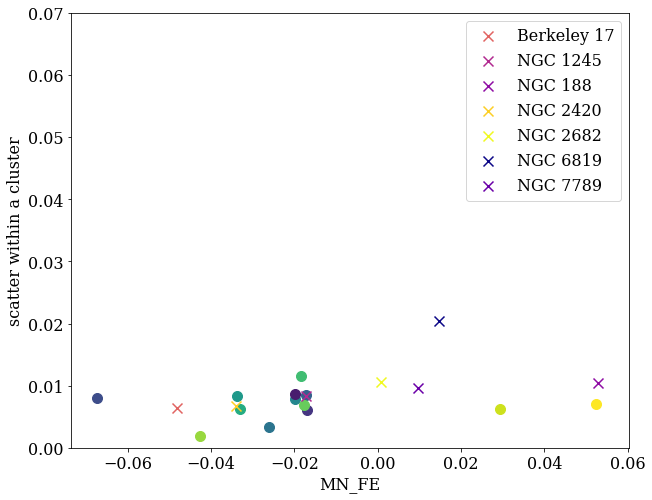

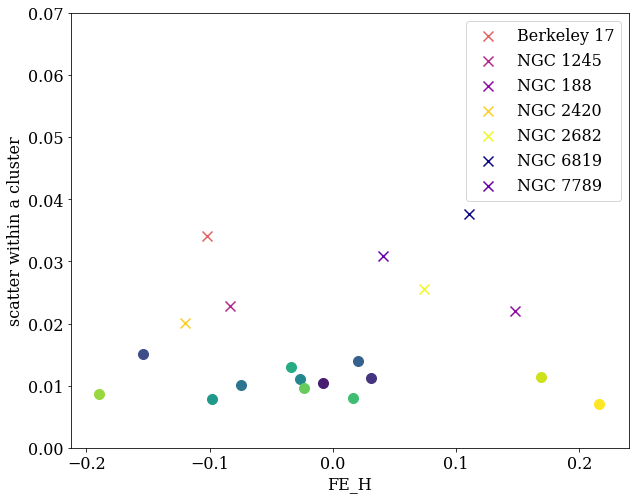

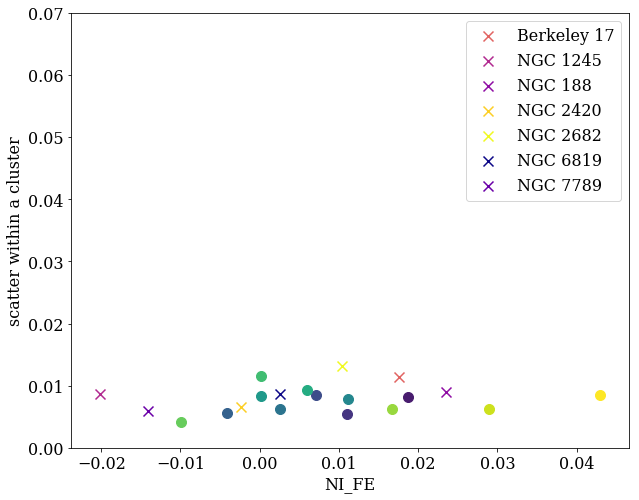

In [26]:
plotcolors = plt.get_cmap('viridis')(np.unique(recolour)/np.max(recolour))
clslist = np.unique(mem[clinds]['CLUSTER'])
occolors = plt.get_cmap('plasma')(np.linspace(0,1,len(clslist)))
sz = 100
for key in keys:
    plt.figure(figsize=(10,8))
    for lab in plabs[goodlabs]:
        match = np.where(labs==lab)
        cind = np.where(colors[lab]==np.unique(recolour))
        meanval = np.mean(allStar[goodstars][match][key])
        stdval = np.std(allStar[goodstars][match][key])
        plt.scatter(meanval,stdval,c=plotcolors[cind],s=sz)
    for c,cluster in enumerate(np.unique(mem[clinds]['CLUSTER'])):
        match = np.where(mem[clinds]['CLUSTER']==cluster)
        if len(match[0])>5:
            cind = ockeys[cluster]
            meanval = np.mean(allStar[goodstars][apinds][match][key])
            stdval = np.std(allStar[goodstars][apinds][match][key])
            plt.scatter(meanval,stdval,color=occolors[cind],zorder=3,marker='x',label=cluster,s=sz)
    plt.ylim(0.,0.07)
    plt.ylabel('scatter within a cluster')
    plt.xlabel(key)
    plt.legend(loc='best')
    plt.savefig('minsize{0}_scale{1}_elems{2}_{3}spread.jpg'.format(minsize,np.round(scalerange[scale],3),len(elems),key))

In [36]:
dist[0][0]

2376.186279296875

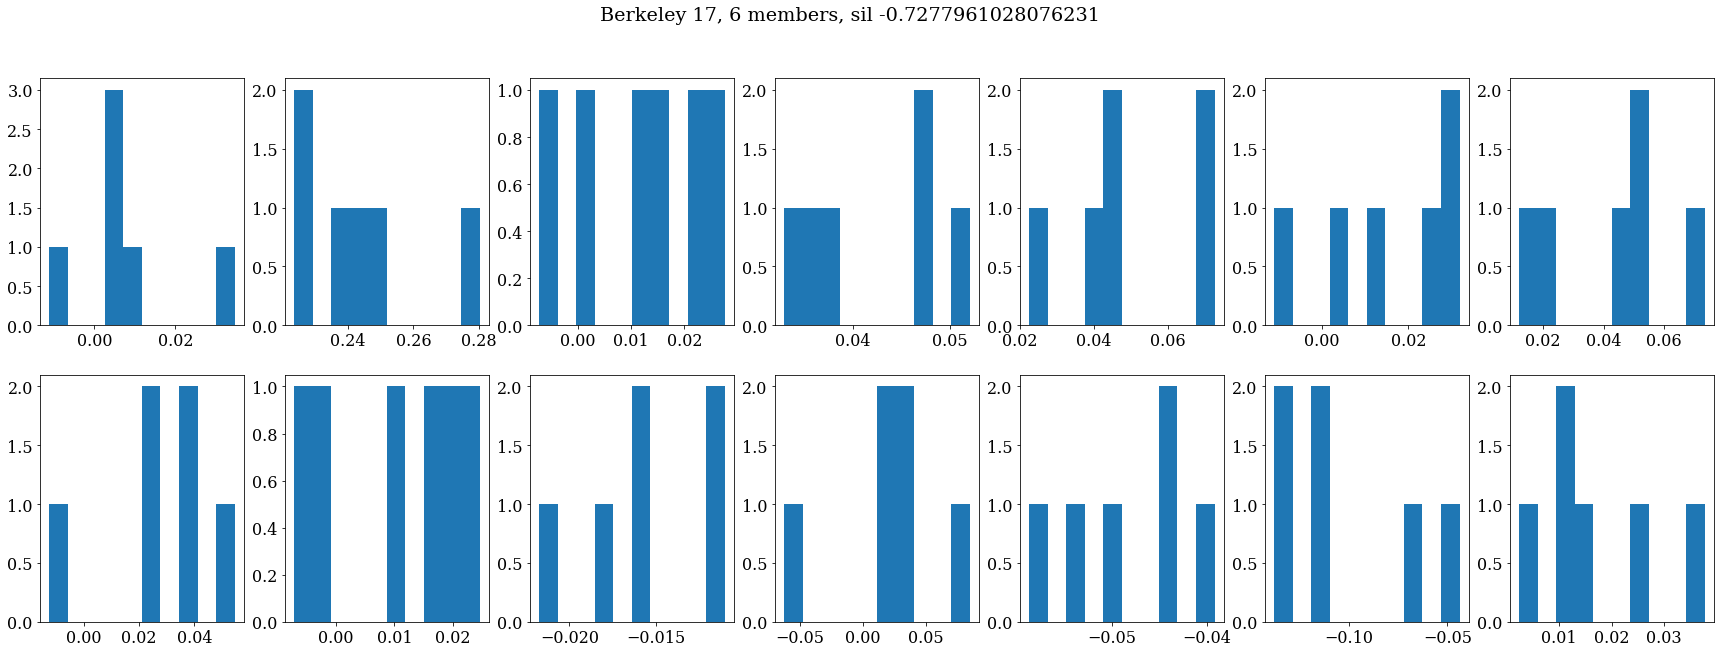

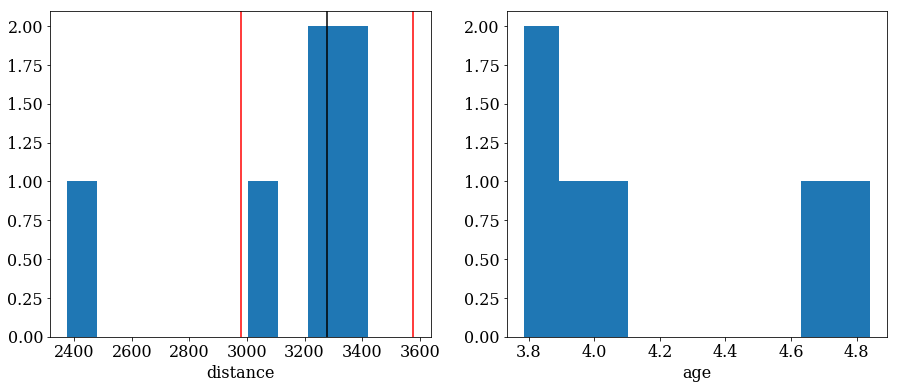

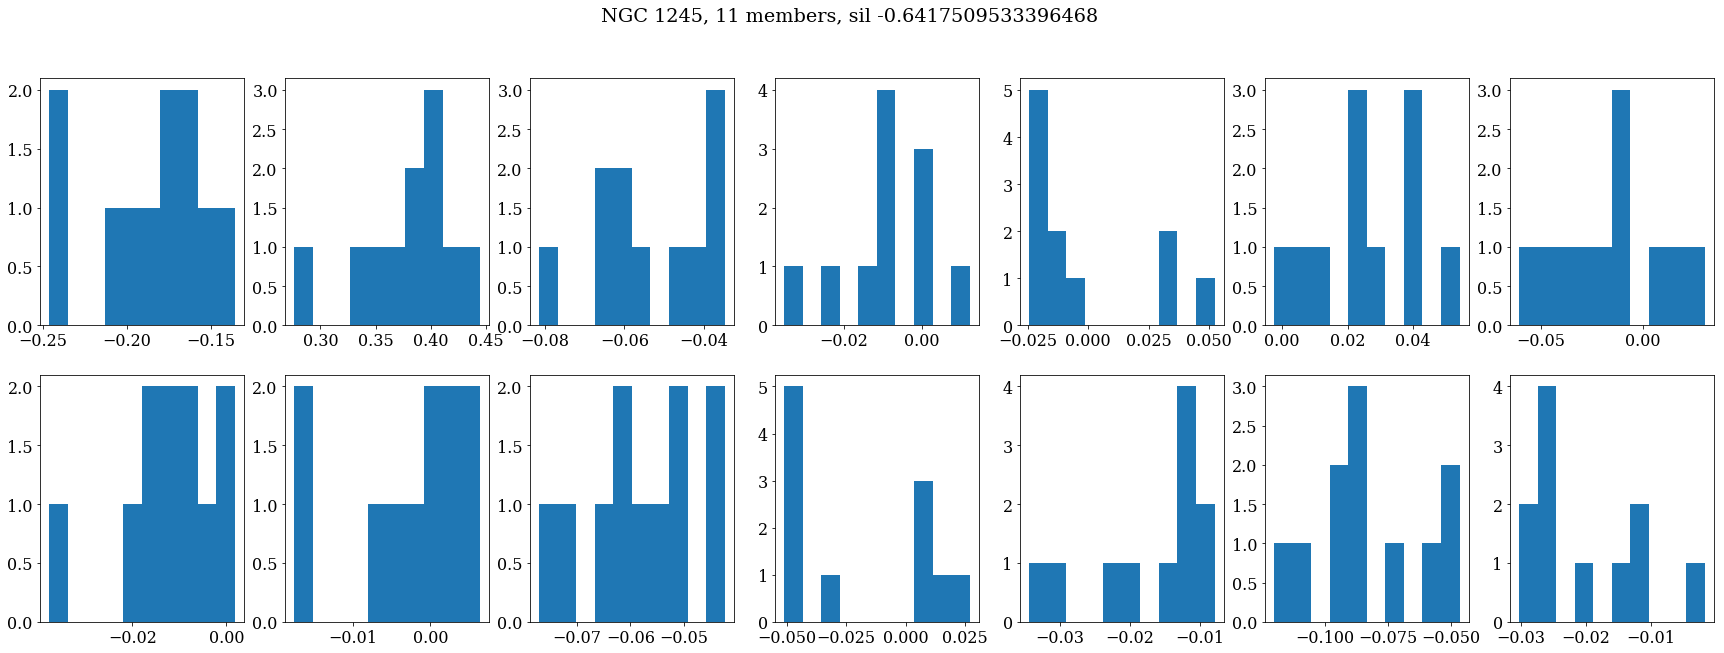

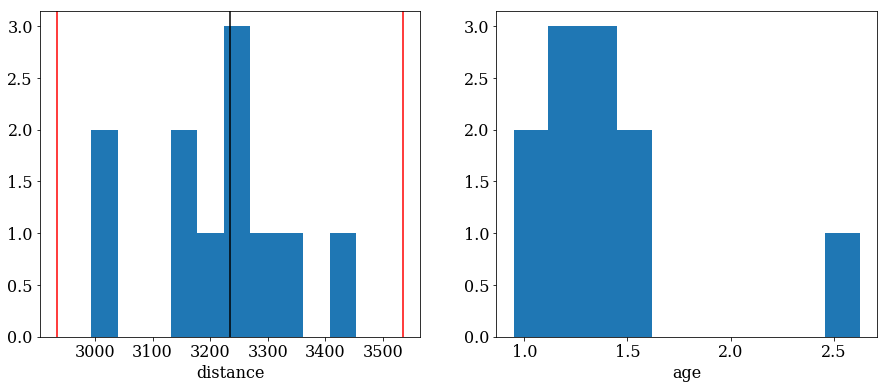

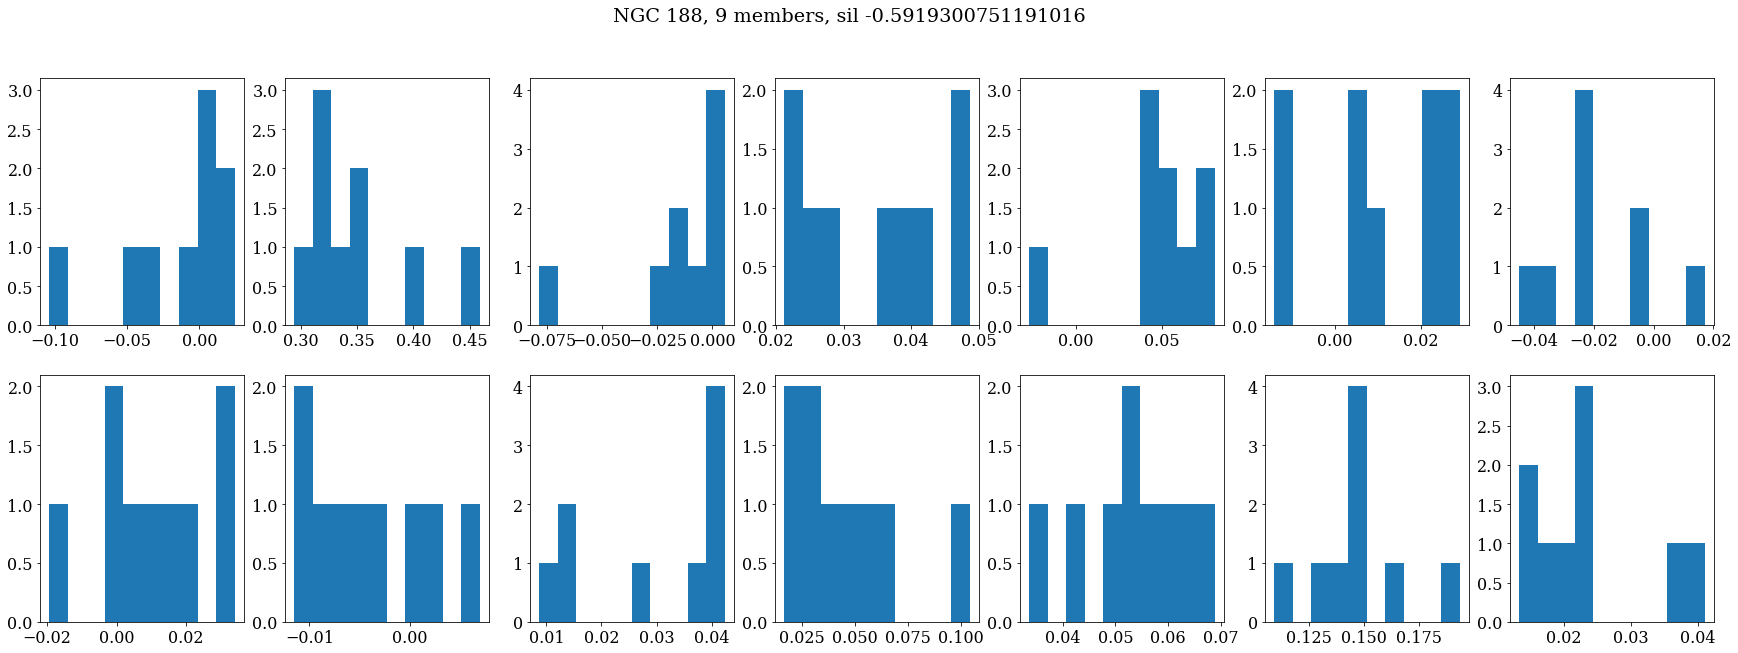

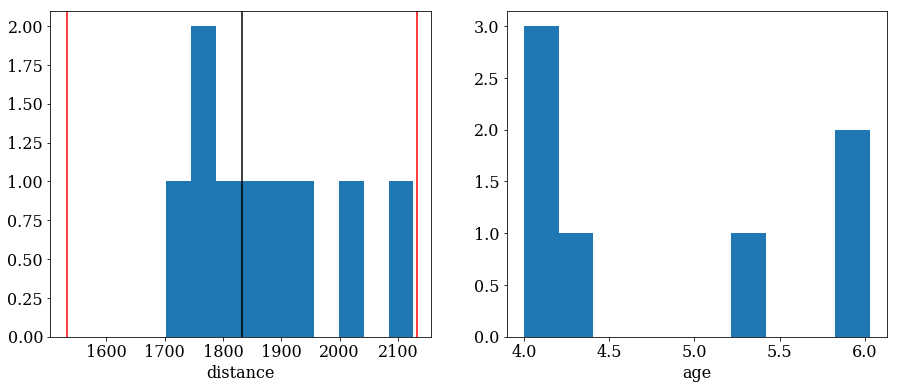

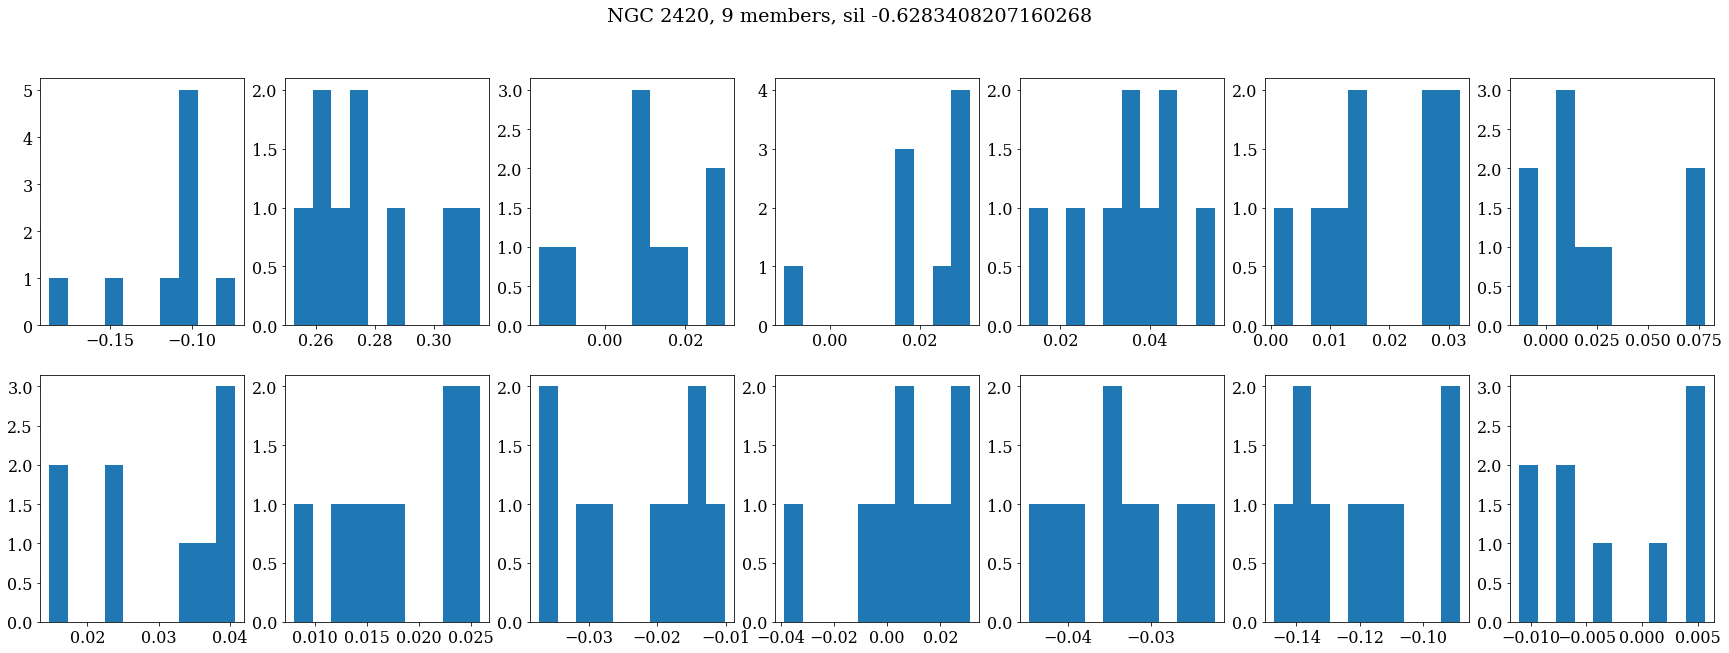

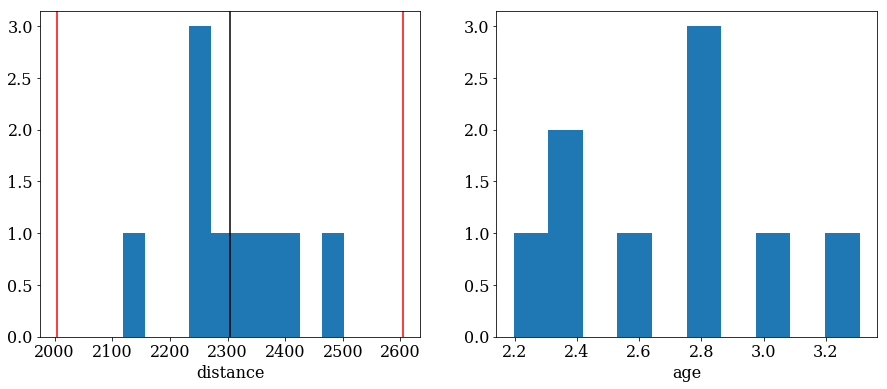

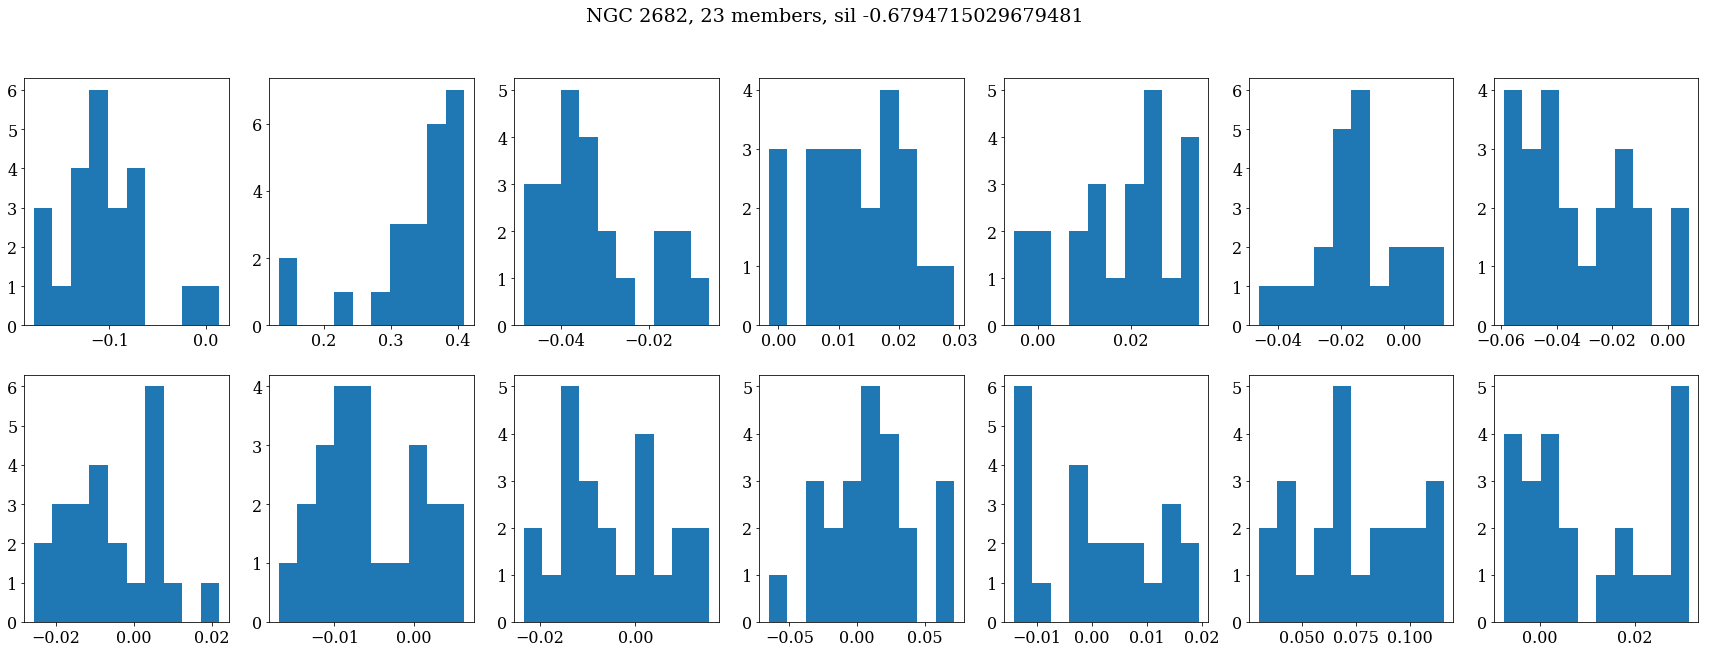

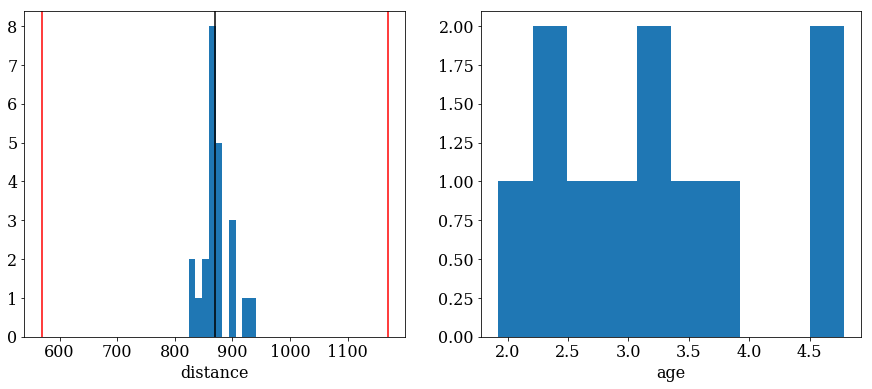

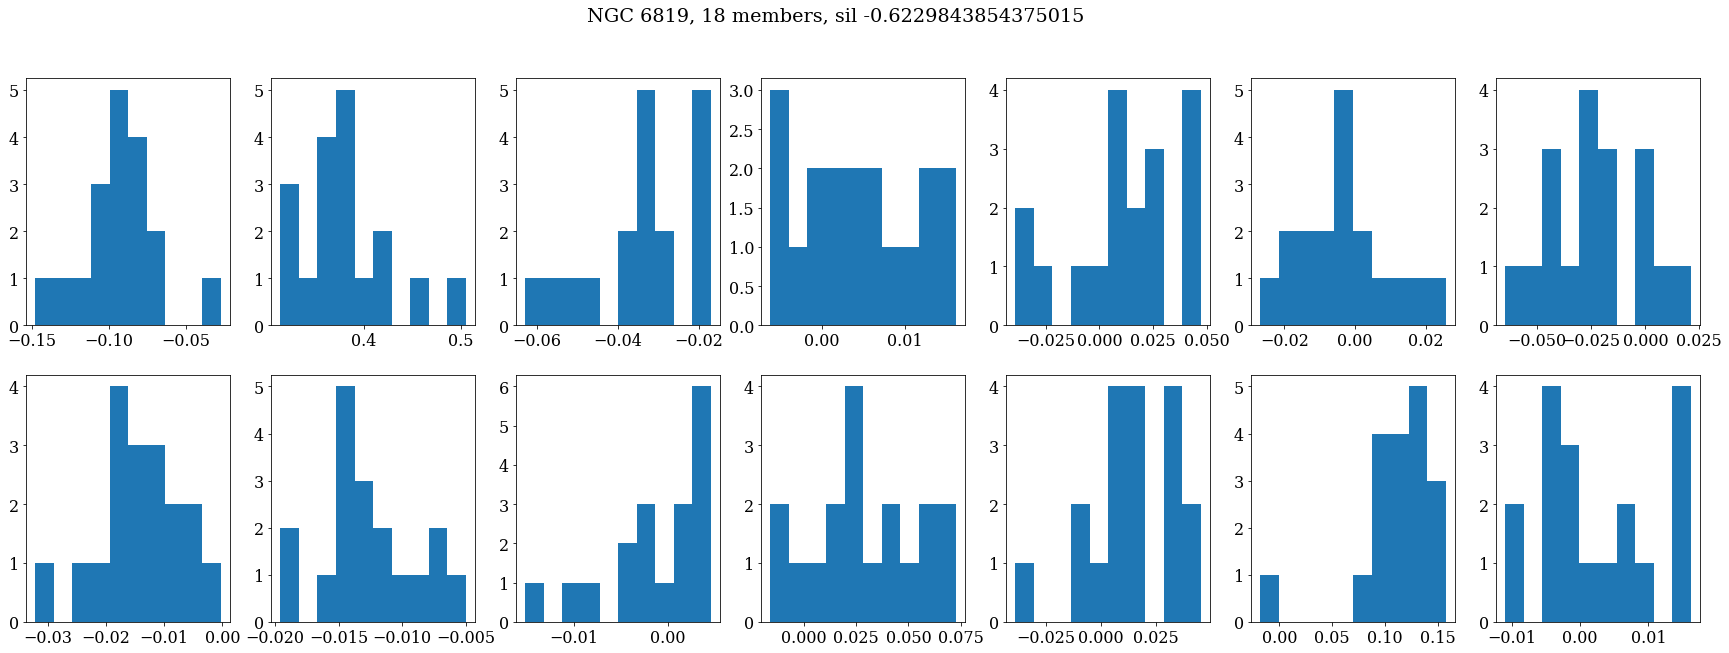

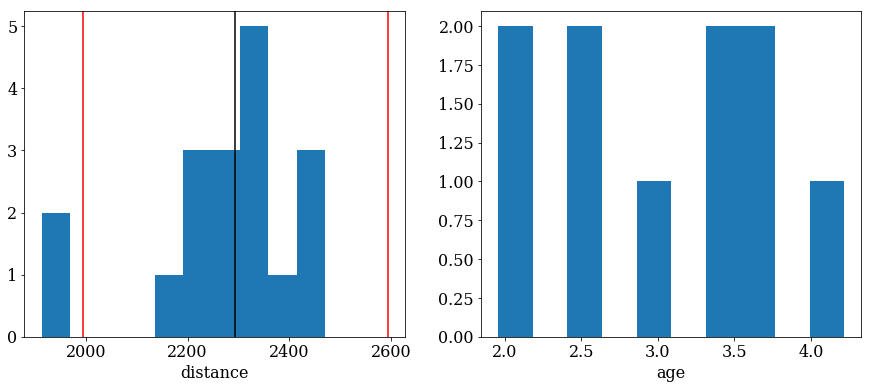

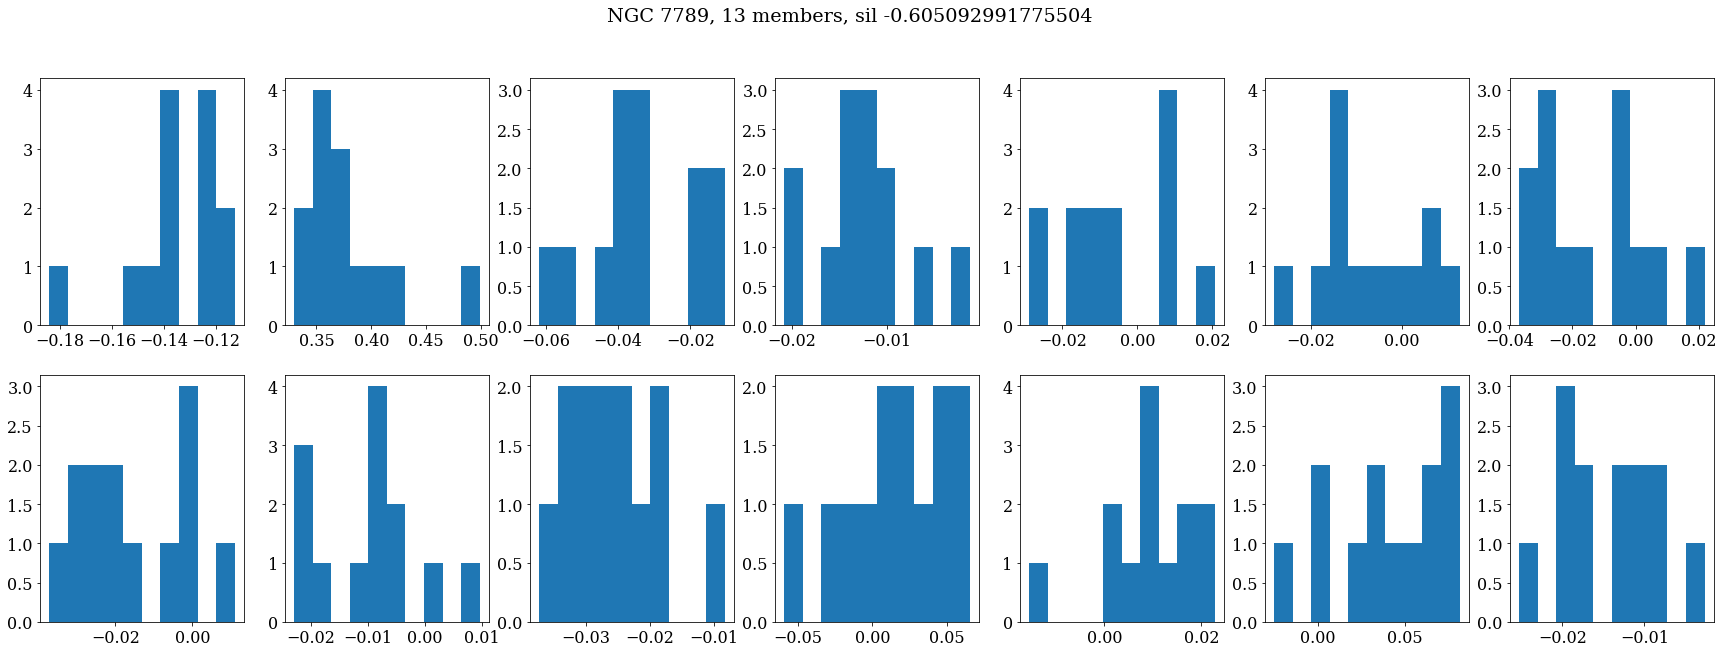

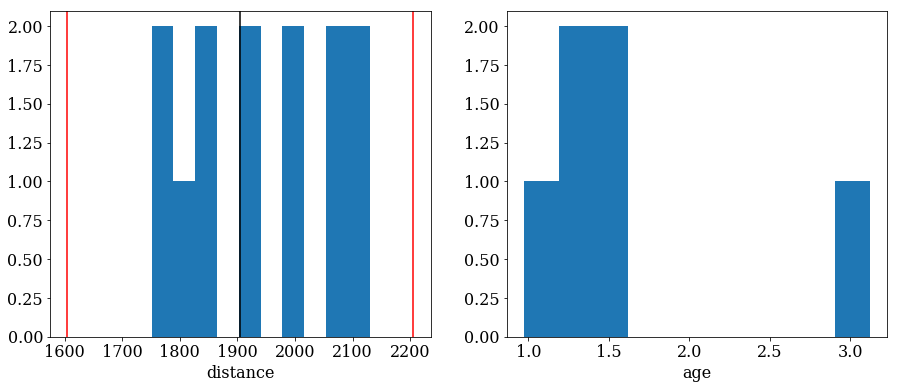

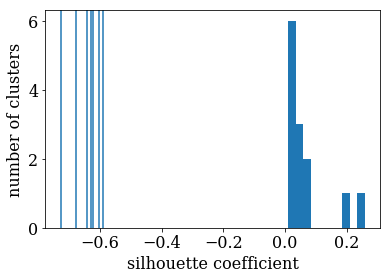

In [40]:
import scipy
ocsils = []
for c,cluster in enumerate(np.unique(mem[clinds]['CLUSTER'])):
    match = np.where(mem[clinds]['CLUSTER']==cluster)
    sil = np.mean(allsils[scale][match])
    if len(match[0])>5:
        plt.figure(figsize=(30,10))
        plt.suptitle('{0}, {2} members, sil {1}'.format(cluster,sil,len(match[0])))
        ocsils.append(sil)
        for k,key in enumerate(keys):
            plt.subplot(2,int(np.ceil(len(keys)/2)),k+1)
            plt.hist(allStar[goodstars][apinds][key][match])
        plt.subplots_adjust(wspace=0.2)
        plt.figure(figsize=(15,6))
        plt.subplot(121)
        dist = np.median(allStar[goodstars][apinds]['dist'][match])
        plt.hist(allStar[goodstars][apinds]['dist'][match])
        plt.axvline(dist,color='k')
        plt.axvline(dist-300,color='r')
        plt.axvline(dist+300,color='r')
        plt.xlabel('distance')
        plt.subplot(122)
        ages = allStar[goodstars][apinds]['astroNN_age'][match]
        plt.hist(ages[ages>-1000])
        plt.xlabel('age')
plt.figure()
plt.hist(clustersils[goodlabs])
for sil in ocsils:
    plt.axvline(sil,)
plt.ylabel('number of clusters')
plt.xlabel('silhouette coefficient')
plt.savefig('minsize{0}_scale{1}_elems{2}_sil.jpg'.format(minsize,np.round(scalerange[scale],3),len(elems)))

In [28]:
key1 = 'FE_H'
key2 = 'MG_FE'
ind1 = np.where(np.array(keys)==key1)
ind2 = np.where(np.array(keys)==key2)

In [26]:
## Clusters smeary because I hadn't purged dwarfs

In [29]:
for i,ind in enumerate(apinds):
    if ind in goodinds:
        print('found a member of {0} labelled {1}'.format(mem[clinds[i]]['CLUSTER'],labs[ind]))

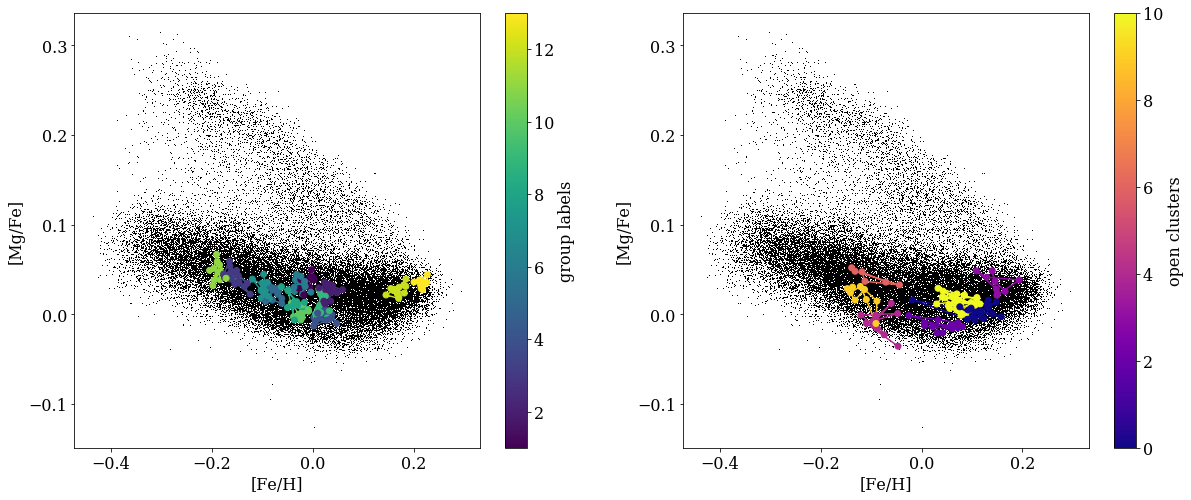

In [50]:
plotcolors = plt.get_cmap('viridis')(np.unique(recolour)/np.max(recolour))
clslist = np.unique(mem[clinds]['CLUSTER'])
occolors = plt.get_cmap('plasma')(np.linspace(0,1,len(clslist)))
fig = plt.figure(figsize=(20,8))
ax = plt.subplot(121)
#histogram2d(fig,ax,allStar[goodstars][key1],allStar[goodstars][key2],bins=100,vmin=1,vmax=110,norm='log',default_cmap='gray_r')
plt.plot(allStar[goodstars][key1],allStar[goodstars][key2],'k,',zorder=0)
members = []
for lab in plabs[goodlabs]:
    match = np.where(labs==lab)
    cind = np.where(colors[lab]==np.unique(recolour))
    plt.plot(allStar[goodstars][match][key1],allStar[goodstars][match][key2],color=plotcolors[cind][0],zorder=1)
    members.append(match[0])
sca = plt.scatter(abundances[:,ind1][:,0][:,0][goodinds],abundances[:,ind2][:,0][:,0][goodinds],c=recolour,cmap='viridis',zorder=2)
plt.colorbar(sca,label='group labels')
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')
plt.subplot(122)
plt.plot(allStar[goodstars][key1],allStar[goodstars][key2],'k,',zorder=0)
bigenough = []
for c,cluster in enumerate(np.unique(mem[clinds]['CLUSTER'])):
    match = np.where(mem[clinds]['CLUSTER']==cluster)
    if len(match[0])>5:
        cind = ockeys[cluster]
        plt.plot(allStar[goodstars][apinds][match][key1],allStar[goodstars][apinds][match][key2],color=occolors[cind],zorder=3)
        bigenough.append(match[0])
bigenough = np.array([item for sublist in bigenough for item in sublist])
sca = plt.scatter(allStar[goodstars][apinds][bigenough][key1],allStar[goodstars][apinds][bigenough][key2],c=np.array(oclabels)[bigenough],cmap='plasma',zorder=4)
plt.colorbar(sca,label='open clusters')
plt.xlabel('[Fe/H]')
plt.ylabel('[Mg/Fe]')
plt.savefig('minsize{0}_scale{1}_elems{2}_Mg_v_Fe.jpg'.format(minsize,np.round(scalerange[scale],3),len(elems)))